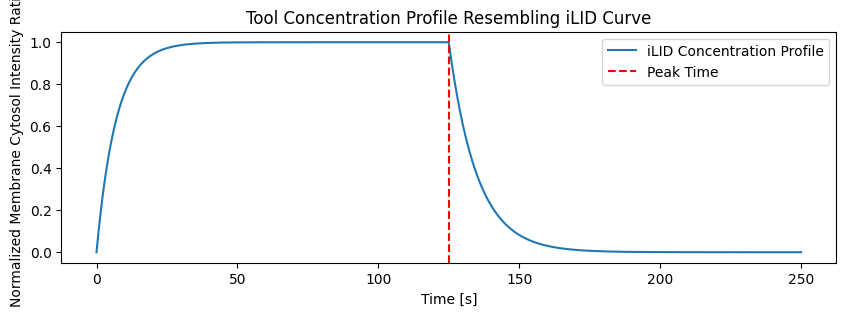

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define time range
time = np.linspace(0, 250, 1000)

# Define parameters for the activation and decay phases
activation_time_constant = 7  # Time constant for activation (adjust to fit curve)
decay_time_constant = 10  # Time constant for decay (adjust to fit curve)
peak_time = 125  # Time when the peak concentration is reached (adjust to fit curve)
peak_concentration = 1  # Peak concentration value (adjust to fit curve)

# Define activation and decay functions
def activation(t, time_constant):
    return peak_concentration * (1 - np.exp(-t / time_constant))

def decay(t, time_constant):
    return peak_concentration * np.exp(-t / time_constant)

# Combine activation and decay phases
def tool_concentration_profile(t, peak_time, activation_time_constant, decay_time_constant):
    activation_phase = (t < peak_time) * activation(t, activation_time_constant)
    decay_phase = (t >= peak_time) * decay(t - peak_time, decay_time_constant)
    return activation_phase + decay_phase

# Generate the tool concentration profile
tool_concentration = tool_concentration_profile(time, peak_time, activation_time_constant, decay_time_constant)

# Plot the concentration profile
plt.figure(figsize=(10, 3))
plt.plot(time, tool_concentration, label='iLID Concentration Profile')
plt.axvline(x=peak_time, color='r', linestyle='--', label='Peak Time')
plt.xlabel('Time [s]')
plt.ylabel('Normalized Membrane Cytosol Intensity Ratio')
plt.title('Tool Concentration Profile Resembling iLID Curve')
plt.legend()
plt.show()

Default speed, + fit scaler

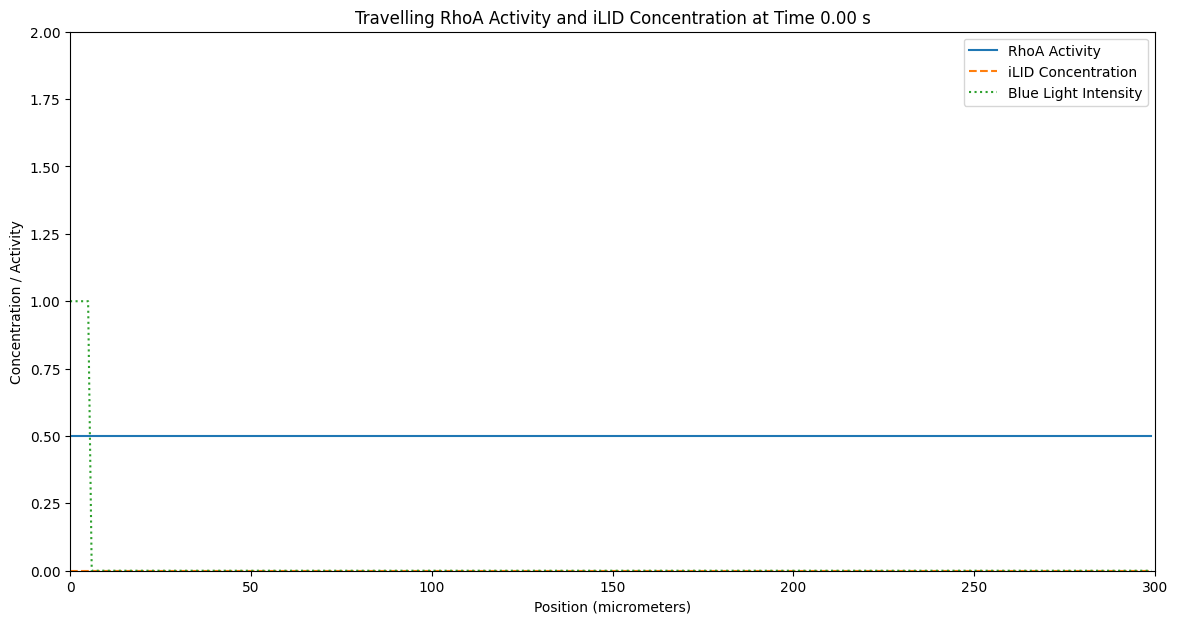

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import MinMaxScaler

# Define parameters for the tool concentration profile
activation_time_constant = 7  # Time constant for activation
decay_time_constant = 10  # Time constant for decay
peak_concentration = 1  # Peak concentration value

# Define other simulation parameters
cell_length = 300.0  # cell length in micrometers
dx = 1.0  # spatial resolution in micrometers
x = np.arange(0, cell_length, dx)  # spatial grid
total_time = 120.0  # total simulation time in seconds
time = np.linspace(0, total_time, 1000)  # time grid
blue_light_speed = cell_length / (total_time)  # speed of the blue light moving across the cell
blue_light_width = 10  # width of the blue light in micrometers

# Base activation and inactivation rates for RhoA
base_activation_rate = 0.1  # base activation rate for RhoA (1/s)
gef_activation_factor = 2  # factor by which GEF activation increases RhoA activation rate
base_inactivation_rate = 0.5  # base inactivation rate for RhoA (1/s)

# Function to create moving blue light stimulation
def blue_light_stimulation(t, x, speed, width):
    center_position = speed * t
    return np.exp(-((x - center_position)**2) / (2 * (width ** 2)))

def blue_light_stimulation(t, x, speed, width, delay = 0):
    t = t - delay
    if t < 0:
        return np.zeros_like(x)
    center_position = speed * t
    return np.where((x >= center_position - width / 2) & (x <= center_position + width / 2), 1, 0)


# Function to compute the derivatives for iLID and RhoA activation
def pde_rhs(t, y, base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, dx, total_time):
    ilid_conc = y[:len(x)]
    rhoa_act = y[len(x):]
    
    blue_light_intensity = blue_light_stimulation(t, x, blue_light_speed, blue_light_width, delay=0)
    
    # Activation and decay of iLID concentration
    d_ilid_dt = blue_light_intensity * (peak_concentration - ilid_conc) / activation_time_constant - ilid_conc / decay_time_constant
    
    # Activation and inactivation of RhoA activity
    activation_rate = base_activation_rate + gef_activation_factor * ilid_conc
    d_rhoa_dt = activation_rate - base_inactivation_rate * rhoa_act
    
    return np.concatenate([d_ilid_dt, d_rhoa_dt])

def simulate(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, total_time):
    ilid_conc = np.zeros_like(x)
    rhoa_activity = np.ones_like(x) *0.5  # initial RhoA activity
    
    # Initial state vector
    y0 = np.concatenate([ilid_conc, rhoa_activity])

    # Time points for the solution
    t_span = (0, total_time)
    t_eval = np.linspace(0, total_time, 100)

    # Solve the PDE
    solution = solve_ivp(pde_rhs, t_span, y0, t_eval=t_eval, args=(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, dx, total_time), method='RK45')

    return solution.y, t_eval

rhoa_activity_over_time, t_eval = simulate(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, total_time)

scaler_c1 = MinMaxScaler()
scaler_c2 = MinMaxScaler()
# rescale to 0-1
scaler_c1.fit(rhoa_activity_over_time[len(x):, :].T)
# rhoa_activity_over_time[len(x):, :] = scaler_c1.transform(rhoa_activity_over_time[len(x):, :].T).T
scaler_c2.fit(rhoa_activity_over_time[:len(x), :].T)
# rhoa_activity_over_time[:len(x), :] = scaler_c2.transform(rhoa_activity_over_time[:len(x), :].T).T

# Create the animation
fig, ax = plt.subplots(figsize=(14, 7))
line_rhoa, = ax.plot(x, rhoa_activity_over_time[len(x):, 0], label='RhoA Activity')
line_ilid, = ax.plot(x, rhoa_activity_over_time[:len(x), 0], linestyle='dashed', label='iLID Concentration')
line_blue_light, = ax.plot(x, blue_light_stimulation(t_eval[0], x, blue_light_speed, blue_light_width), linestyle='dotted', label='Blue Light Intensity')
ax.set_xlim(0, cell_length)
ax.set_ylim(0, 2)
ax.set_xlabel('Position (micrometers)')
ax.set_ylabel('Concentration / Activity')
ax.set_title('Travelling RhoA Activity and iLID Concentration')
ax.legend()

def update(frame):
    line_rhoa.set_ydata(rhoa_activity_over_time[len(x):, frame])
    line_ilid.set_ydata(rhoa_activity_over_time[:len(x), frame])
    line_blue_light.set_ydata(blue_light_stimulation(t_eval[frame], x, blue_light_speed, blue_light_width))
    ax.set_title(f'Travelling RhoA Activity and iLID Concentration at Time {t_eval[frame]:.2f} s')
    return line_rhoa, line_ilid,

ani = FuncAnimation(fig, update, frames=len(t_eval), blit=True)
plt.show()

# Save the animation as a video file
ani.save('Rhoa_Activity_Wave_with_iLID.mp4', writer='ffmpeg', fps=20)


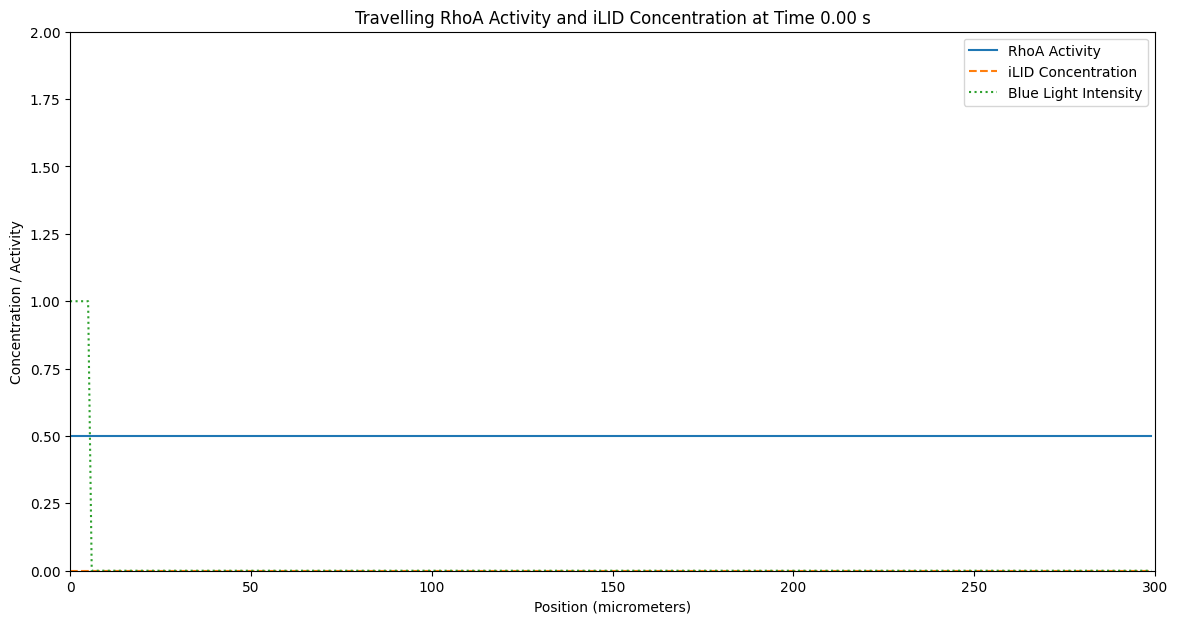

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import MinMaxScaler

# Define parameters for the tool concentration profile
activation_time_constant = 7  # Time constant for activation
decay_time_constant = 10  # Time constant for decay
peak_concentration = 1  # Peak concentration value

# Define other simulation parameters
cell_length = 300.0  # cell length in micrometers
dx = 1.0  # spatial resolution in micrometers
x = np.arange(0, cell_length, dx)  # spatial grid
total_time = 120.0  # total simulation time in seconds
time = np.linspace(0, total_time, 1000)  # time grid
blue_light_speed = cell_length / (total_time *0.5)  # speed of the blue light moving across the cell
blue_light_width = 10  # width of the blue light in micrometers

# Base activation and inactivation rates for RhoA
base_activation_rate = 0.1  # base activation rate for RhoA (1/s)
gef_activation_factor = 2  # factor by which GEF activation increases RhoA activation rate
base_inactivation_rate = 0.5  # base inactivation rate for RhoA (1/s)

# Function to create moving blue light stimulation
def blue_light_stimulation(t, x, speed, width):
    center_position = speed * t
    return np.exp(-((x - center_position)**2) / (2 * (width ** 2)))

def blue_light_stimulation(t, x, speed, width, delay = 0):
    t = t - delay
    if t < 0:
        return np.zeros_like(x)
    center_position = speed * t
    return np.where((x >= center_position - width / 2) & (x <= center_position + width / 2), 1, 0)


# Function to compute the derivatives for iLID and RhoA activation
def pde_rhs(t, y, base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, dx, total_time):
    ilid_conc = y[:len(x)]
    rhoa_act = y[len(x):]
    
    blue_light_intensity = blue_light_stimulation(t, x, blue_light_speed, blue_light_width, delay=0)
    
    # Activation and decay of iLID concentration
    d_ilid_dt = blue_light_intensity * (peak_concentration - ilid_conc) / activation_time_constant - ilid_conc / decay_time_constant
    
    # Activation and inactivation of RhoA activity
    activation_rate = base_activation_rate + gef_activation_factor * ilid_conc
    d_rhoa_dt = activation_rate - base_inactivation_rate * rhoa_act
    
    return np.concatenate([d_ilid_dt, d_rhoa_dt])

def simulate(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, total_time):
    ilid_conc = np.zeros_like(x)
    rhoa_activity = np.ones_like(x) *0.5  # initial RhoA activity
    
    # Initial state vector
    y0 = np.concatenate([ilid_conc, rhoa_activity])

    # Time points for the solution
    t_span = (0, total_time)
    t_eval = np.linspace(0, total_time, 100)

    # Solve the PDE
    solution = solve_ivp(pde_rhs, t_span, y0, t_eval=t_eval, args=(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, dx, total_time), method='RK45')

    return solution.y, t_eval

rhoa_activity_over_time, t_eval = simulate(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, total_time)

scaler_c1 = MinMaxScaler()
scaler_c2 = MinMaxScaler()
# rescale to 0-1
scaler_c1.fit(rhoa_activity_over_time[len(x):, :].T)
# rhoa_activity_over_time[len(x):, :] = scaler_c1.transform(rhoa_activity_over_time[len(x):, :].T).T
scaler_c2.fit(rhoa_activity_over_time[:len(x), :].T)
# rhoa_activity_over_time[:len(x), :] = scaler_c2.transform(rhoa_activity_over_time[:len(x), :].T).T

# Create the animation
fig, ax = plt.subplots(figsize=(14, 7))
line_rhoa, = ax.plot(x, rhoa_activity_over_time[len(x):, 0], label='RhoA Activity')
line_ilid, = ax.plot(x, rhoa_activity_over_time[:len(x), 0], linestyle='dashed', label='iLID Concentration')
line_blue_light, = ax.plot(x, blue_light_stimulation(t_eval[0], x, blue_light_speed, blue_light_width), linestyle='dotted', label='Blue Light Intensity')
ax.set_xlim(0, cell_length)
ax.set_ylim(0, 2)
ax.set_xlabel('Position (micrometers)')
ax.set_ylabel('Concentration / Activity')
ax.set_title('Travelling RhoA Activity and iLID Concentration')
ax.legend()

def update(frame):
    line_rhoa.set_ydata(rhoa_activity_over_time[len(x):, frame])
    line_ilid.set_ydata(rhoa_activity_over_time[:len(x), frame])
    line_blue_light.set_ydata(blue_light_stimulation(t_eval[frame], x, blue_light_speed, blue_light_width))
    ax.set_title(f'Travelling RhoA Activity and iLID Concentration at Time {t_eval[frame]:.2f} s')
    return line_rhoa, line_ilid,

ani = FuncAnimation(fig, update, frames=len(t_eval), blit=True)
plt.show()

# Save the animation as a video file
ani.save('Rhoa_Activity_Wave_with_iLID_0.5.mp4', writer='ffmpeg', fps=20)


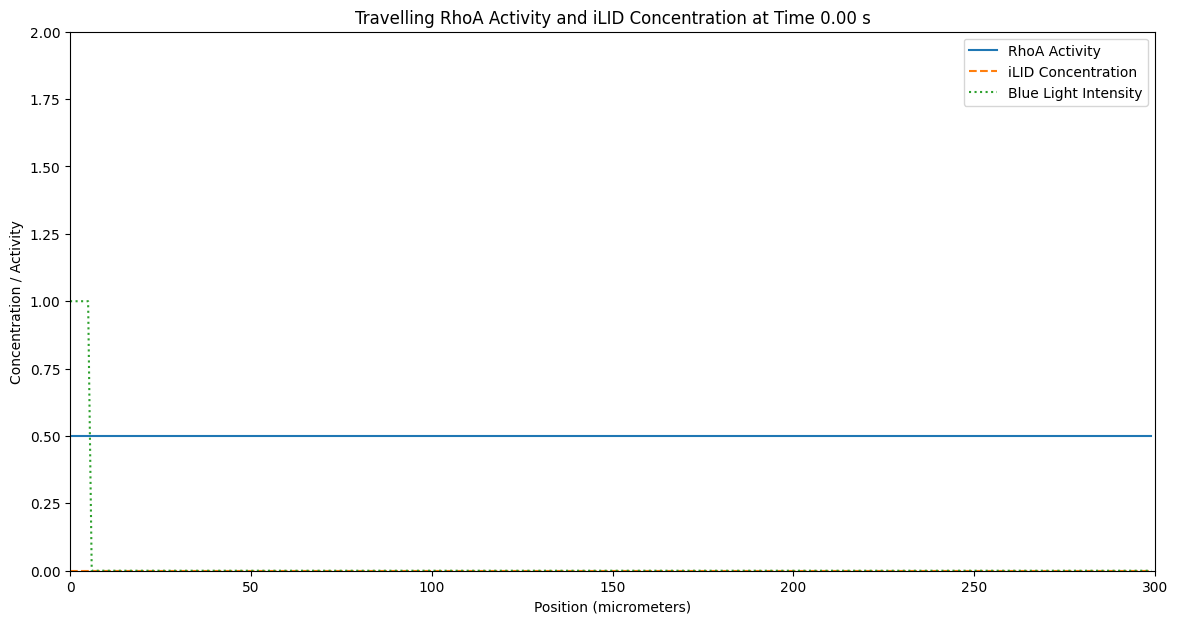

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import MinMaxScaler

# Define parameters for the tool concentration profile
activation_time_constant = 7  # Time constant for activation
decay_time_constant = 10  # Time constant for decay
peak_concentration = 1  # Peak concentration value

# Define other simulation parameters
cell_length = 300.0  # cell length in micrometers
dx = 1.0  # spatial resolution in micrometers
x = np.arange(0, cell_length, dx)  # spatial grid
total_time = 120.0  # total simulation time in seconds
time = np.linspace(0, total_time, 1000)  # time grid
blue_light_speed = cell_length / (total_time *0.1)  # speed of the blue light moving across the cell
blue_light_width = 10  # width of the blue light in micrometers

# Base activation and inactivation rates for RhoA
base_activation_rate = 0.1  # base activation rate for RhoA (1/s)
gef_activation_factor = 2  # factor by which GEF activation increases RhoA activation rate
base_inactivation_rate = 0.5  # base inactivation rate for RhoA (1/s)

# Function to create moving blue light stimulation
def blue_light_stimulation(t, x, speed, width):
    center_position = speed * t
    return np.exp(-((x - center_position)**2) / (2 * (width ** 2)))

def blue_light_stimulation(t, x, speed, width, delay = 0):
    t = t - delay
    if t < 0:
        return np.zeros_like(x)
    center_position = speed * t
    return np.where((x >= center_position - width / 2) & (x <= center_position + width / 2), 1, 0)


# Function to compute the derivatives for iLID and RhoA activation
def pde_rhs(t, y, base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, dx, total_time):
    ilid_conc = y[:len(x)]
    rhoa_act = y[len(x):]
    
    blue_light_intensity = blue_light_stimulation(t, x, blue_light_speed, blue_light_width, delay=0)
    
    # Activation and decay of iLID concentration
    d_ilid_dt = blue_light_intensity * (peak_concentration - ilid_conc) / activation_time_constant - ilid_conc / decay_time_constant
    
    # Activation and inactivation of RhoA activity
    activation_rate = base_activation_rate + gef_activation_factor * ilid_conc
    d_rhoa_dt = activation_rate - base_inactivation_rate * rhoa_act
    
    return np.concatenate([d_ilid_dt, d_rhoa_dt])

def simulate(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, total_time):
    ilid_conc = np.zeros_like(x)
    rhoa_activity = np.ones_like(x) *0.5  # initial RhoA activity
    
    # Initial state vector
    y0 = np.concatenate([ilid_conc, rhoa_activity])

    # Time points for the solution
    t_span = (0, total_time)
    t_eval = np.linspace(0, total_time, 100)

    # Solve the PDE
    solution = solve_ivp(pde_rhs, t_span, y0, t_eval=t_eval, args=(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, dx, total_time), method='RK45')

    return solution.y, t_eval

rhoa_activity_over_time, t_eval = simulate(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, total_time)

scaler_c1 = MinMaxScaler()
scaler_c2 = MinMaxScaler()
# rescale to 0-1
scaler_c1.fit(rhoa_activity_over_time[len(x):, :].T)
# rhoa_activity_over_time[len(x):, :] = scaler_c1.transform(rhoa_activity_over_time[len(x):, :].T).T
scaler_c2.fit(rhoa_activity_over_time[:len(x), :].T)
# rhoa_activity_over_time[:len(x), :] = scaler_c2.transform(rhoa_activity_over_time[:len(x), :].T).T

# Create the animation
fig, ax = plt.subplots(figsize=(14, 7))
line_rhoa, = ax.plot(x, rhoa_activity_over_time[len(x):, 0], label='RhoA Activity')
line_ilid, = ax.plot(x, rhoa_activity_over_time[:len(x), 0], linestyle='dashed', label='iLID Concentration')
line_blue_light, = ax.plot(x, blue_light_stimulation(t_eval[0], x, blue_light_speed, blue_light_width), linestyle='dotted', label='Blue Light Intensity')
ax.set_xlim(0, cell_length)
ax.set_ylim(0, 2)
ax.set_xlabel('Position (micrometers)')
ax.set_ylabel('Concentration / Activity')
ax.set_title('Travelling RhoA Activity and iLID Concentration')
ax.legend()

def update(frame):
    line_rhoa.set_ydata(rhoa_activity_over_time[len(x):, frame])
    line_ilid.set_ydata(rhoa_activity_over_time[:len(x), frame])
    line_blue_light.set_ydata(blue_light_stimulation(t_eval[frame], x, blue_light_speed, blue_light_width))
    ax.set_title(f'Travelling RhoA Activity and iLID Concentration at Time {t_eval[frame]:.2f} s')
    return line_rhoa, line_ilid,

ani = FuncAnimation(fig, update, frames=len(t_eval), blit=True)
plt.show()

# Save the animation as a video file
ani.save('Rhoa_Activity_Wave_with_iLID_0.1.mp4', writer='ffmpeg', fps=20)


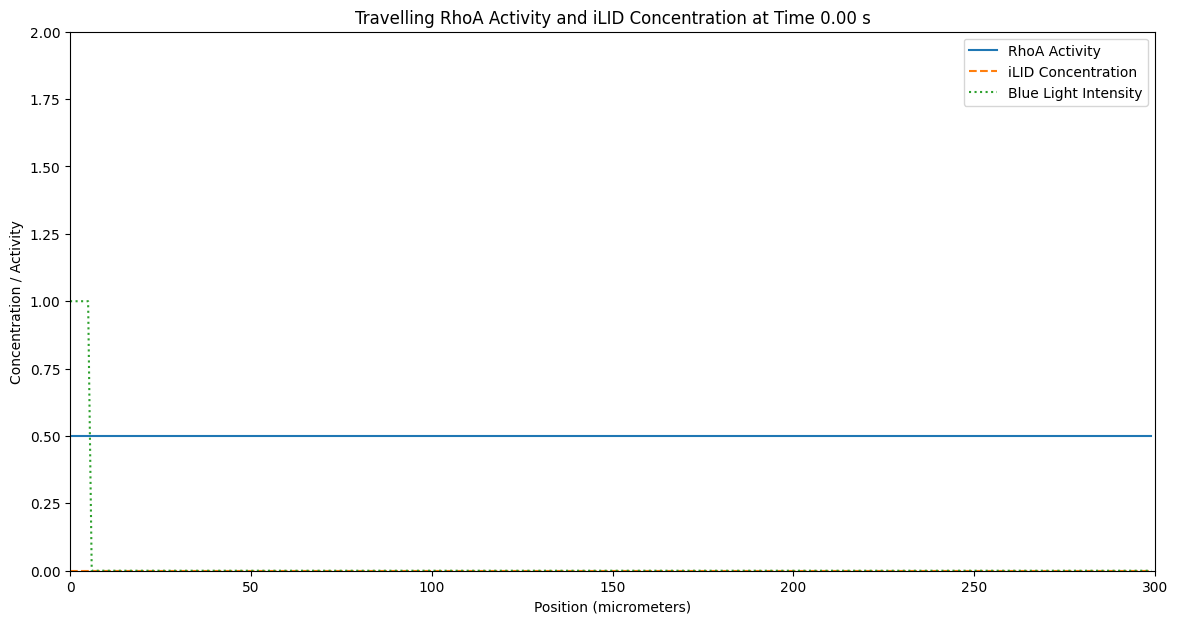

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import MinMaxScaler

# Define parameters for the tool concentration profile
activation_time_constant = 7  # Time constant for activation
decay_time_constant = 10  # Time constant for decay
peak_concentration = 1  # Peak concentration value

# Define other simulation parameters
cell_length = 300.0  # cell length in micrometers
dx = 1.0  # spatial resolution in micrometers
x = np.arange(0, cell_length, dx)  # spatial grid
total_time = 120.0  # total simulation time in seconds
time = np.linspace(0, total_time, 1000)  # time grid
blue_light_speed = cell_length / (total_time *10)  # speed of the blue light moving across the cell
blue_light_width = 10  # width of the blue light in micrometers

# Base activation and inactivation rates for RhoA
base_activation_rate = 0.1  # base activation rate for RhoA (1/s)
gef_activation_factor = 2  # factor by which GEF activation increases RhoA activation rate
base_inactivation_rate = 0.5  # base inactivation rate for RhoA (1/s)

# Function to create moving blue light stimulation
def blue_light_stimulation(t, x, speed, width):
    center_position = speed * t
    return np.exp(-((x - center_position)**2) / (2 * (width ** 2)))

def blue_light_stimulation(t, x, speed, width, delay = 0):
    t = t - delay
    if t < 0:
        return np.zeros_like(x)
    center_position = speed * t
    return np.where((x >= center_position - width / 2) & (x <= center_position + width / 2), 1, 0)


# Function to compute the derivatives for iLID and RhoA activation
def pde_rhs(t, y, base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, dx, total_time):
    ilid_conc = y[:len(x)]
    rhoa_act = y[len(x):]
    
    blue_light_intensity = blue_light_stimulation(t, x, blue_light_speed, blue_light_width, delay=0)
    
    # Activation and decay of iLID concentration
    d_ilid_dt = blue_light_intensity * (peak_concentration - ilid_conc) / activation_time_constant - ilid_conc / decay_time_constant
    
    # Activation and inactivation of RhoA activity
    activation_rate = base_activation_rate + gef_activation_factor * ilid_conc
    d_rhoa_dt = activation_rate - base_inactivation_rate * rhoa_act
    
    return np.concatenate([d_ilid_dt, d_rhoa_dt])

def simulate(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, total_time):
    ilid_conc = np.zeros_like(x)
    rhoa_activity = np.ones_like(x) *0.5  # initial RhoA activity
    
    # Initial state vector
    y0 = np.concatenate([ilid_conc, rhoa_activity])

    # Time points for the solution
    t_span = (0, total_time)
    t_eval = np.linspace(0, total_time, 100)

    # Solve the PDE
    solution = solve_ivp(pde_rhs, t_span, y0, t_eval=t_eval, args=(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, dx, total_time), method='RK45')

    return solution.y, t_eval

rhoa_activity_over_time, t_eval = simulate(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, total_time)

scaler_c1 = MinMaxScaler()
scaler_c2 = MinMaxScaler()
# rescale to 0-1
scaler_c1.fit(rhoa_activity_over_time[len(x):, :].T)
# rhoa_activity_over_time[len(x):, :] = scaler_c1.transform(rhoa_activity_over_time[len(x):, :].T).T
scaler_c2.fit(rhoa_activity_over_time[:len(x), :].T)
# rhoa_activity_over_time[:len(x), :] = scaler_c2.transform(rhoa_activity_over_time[:len(x), :].T).T

# Create the animation
fig, ax = plt.subplots(figsize=(14, 7))
line_rhoa, = ax.plot(x, rhoa_activity_over_time[len(x):, 0], label='RhoA Activity')
line_ilid, = ax.plot(x, rhoa_activity_over_time[:len(x), 0], linestyle='dashed', label='iLID Concentration')
line_blue_light, = ax.plot(x, blue_light_stimulation(t_eval[0], x, blue_light_speed, blue_light_width), linestyle='dotted', label='Blue Light Intensity')
ax.set_xlim(0, cell_length)
ax.set_ylim(0, 2)
ax.set_xlabel('Position (micrometers)')
ax.set_ylabel('Concentration / Activity')
ax.set_title('Travelling RhoA Activity and iLID Concentration')
ax.legend()

def update(frame):
    line_rhoa.set_ydata(rhoa_activity_over_time[len(x):, frame])
    line_ilid.set_ydata(rhoa_activity_over_time[:len(x), frame])
    line_blue_light.set_ydata(blue_light_stimulation(t_eval[frame], x, blue_light_speed, blue_light_width))
    ax.set_title(f'Travelling RhoA Activity and iLID Concentration at Time {t_eval[frame]:.2f} s')
    return line_rhoa, line_ilid,

ani = FuncAnimation(fig, update, frames=len(t_eval), blit=True)
plt.show()

# Save the animation as a video file
ani.save('Rhoa_Activity_Wave_with_iLID_10.mp4', writer='ffmpeg', fps=20)


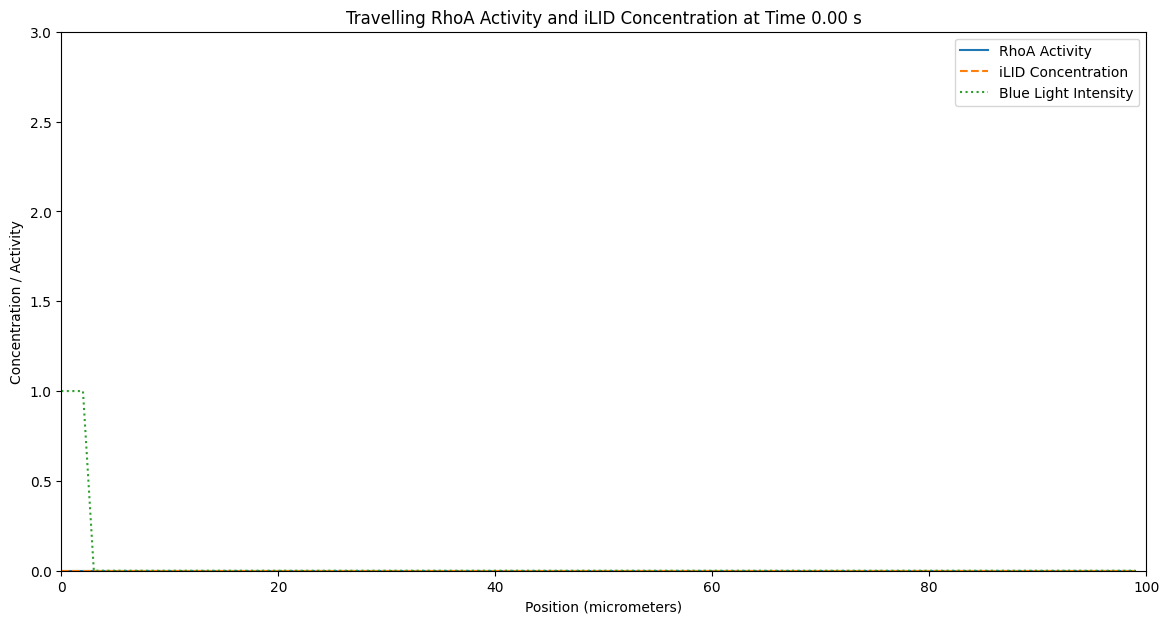

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation

# Define parameters for the tool concentration profile
activation_time_constant = 7  # Time constant for activation
decay_time_constant = 30  # Time constant for decay
peak_concentration = 2  # Peak concentration value
initial_total_ilid = 100  # Initial total available iLID in the cell

# Define other simulation parameters
cell_length = 100.0  # cell length in micrometers
dx = 1.0  # spatial resolution in micrometers
x = np.arange(0, cell_length, dx)  # spatial grid
total_time = 250.0  # total simulation time in seconds
time = np.linspace(0, total_time, 1000)  # time grid
blue_light_speed = cell_length / total_time  # speed of the blue light moving across the cell
blue_light_width = 5  # width of the blue light in micrometers

# Base activation and inactivation rates for RhoA
base_activation_rate = 1  # base activation rate for RhoA (1/s)
gef_activation_factor = 50  # factor by which GEF activation increases RhoA activation rate
base_inactivation_rate = 40  # base inactivation rate for RhoA (1/s)

# Function to create moving blue light stimulation
def blue_light_stimulation(t, x, speed, width):
    center_position = speed * t
    return np.where((x >= center_position - width / 2) & (x <= center_position + width / 2), 1, 0)

# Function to compute the derivatives for iLID and RhoA activation
def pde_rhs(t, y, base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, initial_total_ilid, activation_time_constant, decay_time_constant):
    ilid_conc = y[:len(x)]
    rhoa_act = y[len(x):]

    blue_light_intensity = blue_light_stimulation(t, x, blue_light_speed, blue_light_width)

    # Calculate the total bound iLID and the free iLID pool
    total_bound_ilid = np.sum(ilid_conc)
    free_ilid_pool = initial_total_ilid - total_bound_ilid

    # Redistribution of iLID
    recruitment = blue_light_intensity * np.minimum((peak_concentration - ilid_conc) / activation_time_constant, free_ilid_pool / np.sum(blue_light_intensity))
    decay = ilid_conc / decay_time_constant

    d_ilid_dt = recruitment - decay

    # Activation and inactivation of RhoA activity
    activation_rate = base_activation_rate + gef_activation_factor * ilid_conc
    d_rhoa_dt = activation_rate * (1 - rhoa_act) - base_inactivation_rate * rhoa_act

    return np.concatenate([d_ilid_dt, d_rhoa_dt])

def simulate(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, total_time, initial_total_ilid, activation_time_constant, decay_time_constant):
    ilid_conc = np.zeros_like(x)
    rhoa_activity = np.zeros_like(x)
    
    # Initial state vector
    y0 = np.concatenate([ilid_conc, rhoa_activity])

    # Time points for the solution
    t_span = (0, total_time)
    t_eval = np.linspace(0, total_time, 100)

    # Solve the PDE
    solution = solve_ivp(pde_rhs, t_span, y0, t_eval=t_eval, args=(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, initial_total_ilid, activation_time_constant, decay_time_constant), method='RK45')

    return solution.y, t_eval

rhoa_activity_over_time, t_eval = simulate(base_activation_rate, gef_activation_factor, base_inactivation_rate, blue_light_speed, blue_light_width, total_time, initial_total_ilid, activation_time_constant, decay_time_constant)

# Create the animation
fig, ax = plt.subplots(figsize=(14, 7))
line_rhoa, = ax.plot(x, rhoa_activity_over_time[len(x):, 0], label='RhoA Activity')
line_ilid, = ax.plot(x, rhoa_activity_over_time[:len(x), 0], linestyle='dashed', label='iLID Concentration')
line_blue_light, = ax.plot(x, blue_light_stimulation(t_eval[0], x, blue_light_speed, blue_light_width), linestyle='dotted', label='Blue Light Intensity')
ax.set_xlim(0, cell_length)
ax.set_ylim(0, peak_concentration + 1)
ax.set_xlabel('Position (micrometers)')
ax.set_ylabel('Concentration / Activity')
ax.set_title('Travelling RhoA Activity and iLID Concentration')
ax.legend()

def update(frame):
    line_rhoa.set_ydata(rhoa_activity_over_time[len(x):, frame])
    line_ilid.set_ydata(rhoa_activity_over_time[:len(x), frame])
    line_blue_light.set_ydata(blue_light_stimulation(t_eval[frame], x, blue_light_speed, blue_light_width))
    ax.set_title(f'Travelling RhoA Activity and iLID Concentration at Time {t_eval[frame]:.2f} s')
    return line_rhoa, line_ilid, line_blue_light

ani = FuncAnimation(fig, update, frames=len(t_eval), blit=True)
plt.show()

# Save the animation as a video file
ani.save('Rhoa_Activity_Wave_with_iLID.mp4', writer='ffmpeg', fps=20)


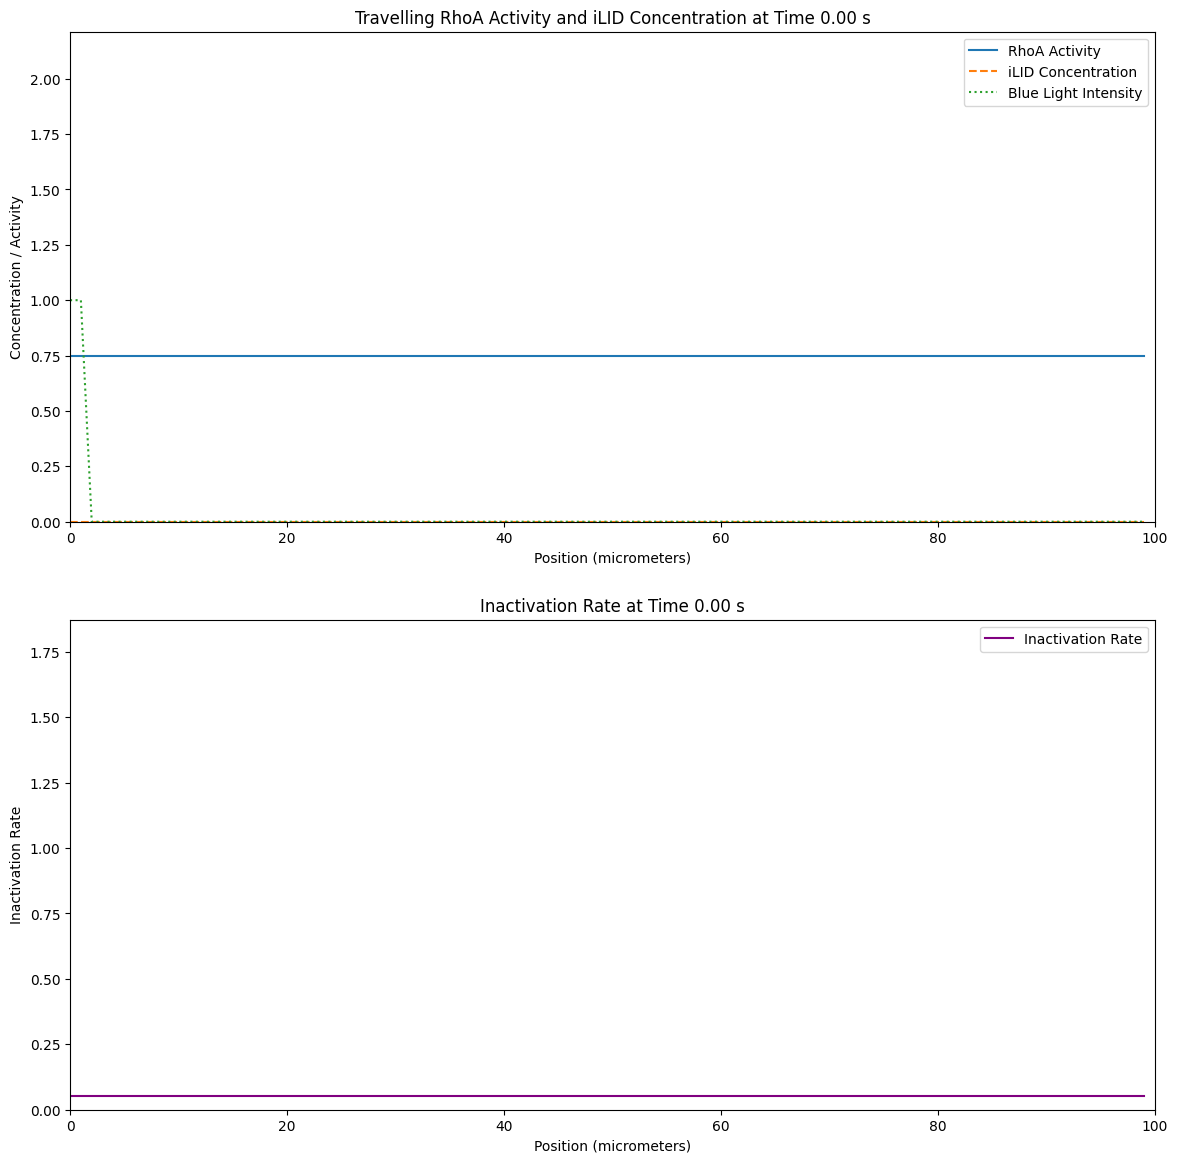

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation

# Define parameters for the tool concentration profile
activation_time_constant = 7  # Time constant for activation
decay_time_constant = 30  # Time constant for decay
peak_concentration = 2  # Peak concentration value
initial_total_ilid = 1000  # Initial total available iLID in the cell

# Define other simulation parameters
cell_length = 100.0  # cell length in micrometers
dx = 1.0  # spatial resolution in micrometers
x = np.arange(0, cell_length, dx)  # spatial grid
total_time = 250.0  # total simulation time in seconds
time = np.linspace(0, total_time, 1000)  # time grid
blue_light_speed = cell_length / total_time  # speed of the blue light moving across the cell
blue_light_width = 2  # width of the blue light in micrometers

# Base activation rate for RhoA
base_activation_rate = 0.1  # base activation rate for RhoA (1/s)
gef_activation_factor = 1  # factor by which GEF activation increases RhoA activation rate
base_inactivation_rate = 1  # base inactivation rate for RhoA (1/s)
hill_coefficient = 10  # Hill coefficient for the feedback (increased for stronger feedback)
dissociation_constant = 1  # Dissociation constant for the feedback (decreased for stronger feedback)

# Function to create moving blue light stimulation
def blue_light_stimulation(t, x, speed, width):
    center_position = speed * t
    return np.where((x >= center_position - width / 2) & (x <= center_position + width / 2), 1, 0)

# Hill function for inactivation
def hill_inactivation(rhoa, K_d, n):
    return base_inactivation_rate * (rhoa**n / (K_d**n + rhoa**n))

# Function to compute the derivatives for iLID and RhoA activation
def pde_rhs(t, y, base_activation_rate, gef_activation_factor, base_inactivation_rate, hill_coefficient, dissociation_constant, blue_light_speed, blue_light_width, initial_total_ilid, activation_time_constant, decay_time_constant, base_rhoa_activity):
    ilid_conc = y[:len(x)]
    rhoa_act = y[len(x):]

    blue_light_intensity = blue_light_stimulation(t, x, blue_light_speed, blue_light_width)

    # Calculate the total bound iLID and the free iLID pool
    total_bound_ilid = np.sum(ilid_conc)
    free_ilid_pool = initial_total_ilid - total_bound_ilid

    # Redistribution of iLID
    recruitment = blue_light_intensity * np.minimum((peak_concentration - ilid_conc) / activation_time_constant, free_ilid_pool / np.sum(blue_light_intensity))
    decay = ilid_conc / decay_time_constant

    d_ilid_dt = recruitment - decay

    # Activation and inactivation of RhoA activity
    activation_rate = base_activation_rate + gef_activation_factor * ilid_conc
    inactivation_rate = hill_inactivation(rhoa_act, dissociation_constant, hill_coefficient)
    
    # Modified RhoA dynamics equation
    d_rhoa_dt = activation_rate - rhoa_act*inactivation_rate

    return np.concatenate([d_ilid_dt, d_rhoa_dt])

def simulate(base_activation_rate, gef_activation_factor, hill_coefficient, dissociation_constant, blue_light_speed, blue_light_width, total_time, initial_total_ilid, activation_time_constant, decay_time_constant):
    base_rhoa_activity = 0.75  # or whatever value is appropriate for your system
    ilid_conc = np.zeros_like(x)
    rhoa_activity = np.full_like(x, base_rhoa_activity)
    y0 = np.concatenate([ilid_conc, rhoa_activity])

    # Time points for the solution
    t_span = (0, total_time)
    t_eval = np.linspace(0, total_time, 100)

    solution = solve_ivp(pde_rhs, t_span, y0, t_eval=t_eval, 
                        args=(base_activation_rate, gef_activation_factor, base_inactivation_rate, 
                            hill_coefficient, dissociation_constant, blue_light_speed, blue_light_width, 
                            initial_total_ilid, activation_time_constant, decay_time_constant, base_rhoa_activity), 
                        method='RK45')
    return solution.y, t_eval

rhoa_activity_over_time, t_eval = simulate(base_activation_rate, gef_activation_factor, hill_coefficient, dissociation_constant, blue_light_speed, blue_light_width, total_time, initial_total_ilid, activation_time_constant, decay_time_constant)

# Calculate inactivation rates
inactivation_rates = np.array([hill_inactivation(rhoa_activity_over_time[len(x):, i], dissociation_constant, hill_coefficient) for i in range(rhoa_activity_over_time.shape[1])])

# Create the animation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

line_rhoa, = ax1.plot(x, rhoa_activity_over_time[len(x):, 0], label='RhoA Activity')
line_ilid, = ax1.plot(x, rhoa_activity_over_time[:len(x), 0], linestyle='dashed', label='iLID Concentration')
line_blue_light, = ax1.plot(x, blue_light_stimulation(t_eval[0], x, blue_light_speed, blue_light_width), linestyle='dotted', label='Blue Light Intensity')
ax1.set_xlim(0, cell_length)
ax1.set_ylim(0, rhoa_activity_over_time.max() + 1)
ax1.set_xlabel('Position (micrometers)')
ax1.set_ylabel('Concentration / Activity')
ax1.set_title('Travelling RhoA Activity and iLID Concentration')
ax1.legend()

line_inactivation, = ax2.plot(x, inactivation_rates[0], label='Inactivation Rate', color='purple')
ax2.set_xlim(0, cell_length)
ax2.set_ylim(0, inactivation_rates.max() + 1)
ax2.set_xlabel('Position (micrometers)')
ax2.set_ylabel('Inactivation Rate')
ax2.set_title('Inactivation Rate over Time')
ax2.legend()

def update(frame):
    rhoa_activity = rhoa_activity_over_time[len(x):, frame]
    inactivation_rate = hill_inactivation(rhoa_activity, dissociation_constant, hill_coefficient)
    
    line_rhoa.set_ydata(rhoa_activity)
    line_ilid.set_ydata(rhoa_activity_over_time[:len(x), frame])
    line_blue_light.set_ydata(blue_light_stimulation(t_eval[frame], x, blue_light_speed, blue_light_width))
    line_inactivation.set_ydata(inactivation_rate)
    
    ax1.set_title(f'Travelling RhoA Activity and iLID Concentration at Time {t_eval[frame]:.2f} s')
    ax2.set_title(f'Inactivation Rate at Time {t_eval[frame]:.2f} s')
    return line_rhoa, line_ilid, line_blue_light, line_inactivation

ani = FuncAnimation(fig, update, frames=len(t_eval), blit=True)
plt.show()

# Save the animation as a video file
ani.save('Rhoa_Activity_Wave_with_iLID_and_Strong_Negative_Feedback.mp4', writer='ffmpeg', fps=20)


In [186]:
rhoa_activity_over_time

array([[0.00000000e+00, 2.32335740e-01, 9.20431559e-02, ...,
        8.98191434e-04, 3.55831500e-04, 1.40967784e-04],
       [0.00000000e+00, 4.10690219e-01, 1.62700856e-01, ...,
        1.58769562e-03, 6.28988536e-04, 2.49182886e-04],
       [0.00000000e+00, 4.49733252e-01, 1.78168318e-01, ...,
        1.73863287e-03, 6.88784507e-04, 2.72871923e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

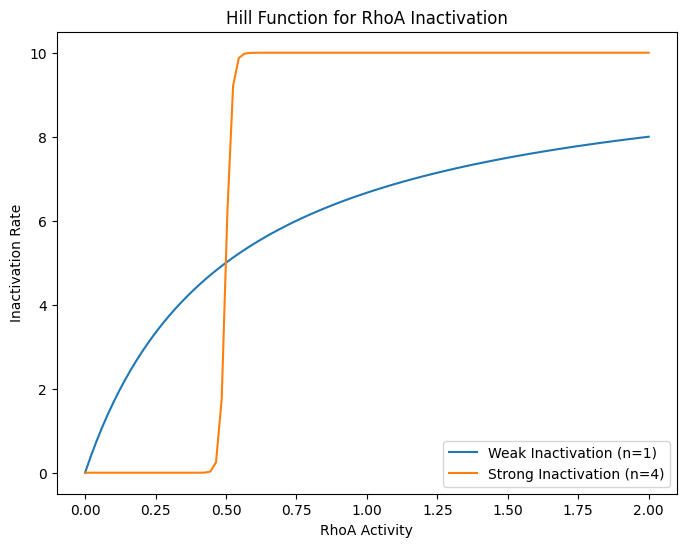

In [3]:
# Hill function for inactivation
def hill_inactivation(rhoa, K_d, n):
    return base_inactivation_rate * (rhoa**n / (K_d**n + rhoa**n))

base_inactivation_rate = 10
hill_coefficient = 50  # Hill coefficient for the feedback (increased for stronger feedback)
dissociation_constant = 0.5  # Dissociation constant for the feedback (decreased for stronger feedback)

# Define RhoA activity range
rhoa_values = np.linspace(0, 2, 100)

# Calculate inactivation rates for different RhoA activity levels
inactivation_rates_weak = hill_inactivation(rhoa_values, dissociation_constant, 1)
inactivation_rates_strong = hill_inactivation(rhoa_values, dissociation_constant, hill_coefficient)

# Plot the inactivation rates
plt.figure(figsize=(8, 6))
plt.plot(rhoa_values, inactivation_rates_weak, label='Weak Inactivation (n=1)')
plt.plot(rhoa_values, inactivation_rates_strong, label='Strong Inactivation (n=4)')
plt.xlabel('RhoA Activity')
plt.ylabel('Inactivation Rate')
plt.title('Hill Function for RhoA Inactivation')
plt.legend()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from diffeqpy import de
from collections import deque

# Define parameters
activation_time_constant = 7
decay_time_constant = 30
peak_concentration = 1
initial_total_ilid = 1000

cell_length = 100.0
dx = 1.0
x = np.arange(0, cell_length, dx)
total_time = 750
time_steps = 100
blue_light_speed = cell_length / total_time * 2
blue_light_width = 2
delay = 100

base_activation_rate = 0.1
gef_activation_factor = 1
base_inactivation_rate = 1
hill_coefficient = 20
dissociation_constant = 15
feedback_threshold = 0.8

# Diffusion coefficients
diffusion_coefficient_rhoa = 0.1
diffusion_coefficient_ilid = 0.01

def blue_light_stimulation(t, x, speed, width):
    center_position = speed * t
    return np.where((x >= center_position - width / 2) & (x <= center_position + width / 2), 1, 0)

def hill_inactivation(rhoa, K_d, n):
    above_threshold = np.maximum(rhoa - feedback_threshold, 0)
    return base_inactivation_rate * (above_threshold**n / (K_d**n + above_threshold**n))

def diffusion_term(y, dx, coefficient):
    return coefficient * (np.roll(y, -1) - 2 * y + np.roll(y, 1)) / dx**2

def dde_system(du, u, h, p, t):
    base_activation_rate, gef_activation_factor, base_inactivation_rate, hill_coefficient, dissociation_constant, blue_light_speed, blue_light_width, initial_total_ilid, activation_time_constant, decay_time_constant, delay, dx, diffusion_coefficient_rhoa, diffusion_coefficient_ilid = p
    ilid_conc = u[:len(x)]
    rhoa_act = u[len(x):]

    blue_light_intensity = blue_light_stimulation(t, x, blue_light_speed, blue_light_width)

    total_bound_ilid = np.sum(ilid_conc)
    free_ilid_pool = initial_total_ilid - total_bound_ilid

    recruitment = blue_light_intensity * np.minimum((peak_concentration - ilid_conc) / activation_time_constant, free_ilid_pool / np.sum(blue_light_intensity))
    decay = ilid_conc / decay_time_constant

    d_ilid_dt = recruitment - decay + diffusion_term(ilid_conc, dx, diffusion_coefficient_ilid)

    activation_rate = base_activation_rate + gef_activation_factor * ilid_conc

    if t > delay:
        delayed_rhoa_act = h(t - delay)[len(x):]
        delayed_rhoa_act = gaussian_filter1d(delayed_rhoa_act, sigma=2)
        delayed_rhoa_act += diffusion_term(rhoa_act, dx, diffusion_coefficient_rhoa)
    else:
        delayed_rhoa_act = rhoa_act

    inactivation_rate = hill_inactivation(delayed_rhoa_act, dissociation_constant, hill_coefficient)
    d_rhoa_dt = activation_rate - rhoa_act * inactivation_rate + diffusion_term(rhoa_act, dx, diffusion_coefficient_rhoa)

    du[:len(x)] = d_ilid_dt
    du[len(x):] = d_rhoa_dt

# Initial conditions
base_rhoa_activity = 0.75
ilid_conc = np.zeros_like(x)
rhoa_activity = np.full_like(x, base_rhoa_activity)
y0 = np.concatenate([ilid_conc, rhoa_activity])

# Define the DDE problem
lags = [delay]
params = (base_activation_rate, gef_activation_factor, base_inactivation_rate, hill_coefficient, dissociation_constant, blue_light_speed, blue_light_width, initial_total_ilid, activation_time_constant, decay_time_constant, delay, dx, diffusion_coefficient_rhoa, diffusion_coefficient_ilid)
prob = de.DDEProblem(dde_system, y0, lags, (0, total_time), params=params)

# Solve the DDE problem
sol = de.solve(prob, de.Tsit5(), saveat=np.linspace(0, total_time, time_steps))

# Extract results
rhoa_activity_over_time = np.array([sol[i][len(x):] for i in range(len(sol.t))]).T
ilid_conc_over_time = np.array([sol[i][:len(x)] for i in range(len(sol.t))]).T
t_eval = sol.t

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

line_rhoa, = ax1.plot(x, rhoa_activity_over_time[:, 0], label="RhoA Activity")
line_ilid, = ax1.plot(x, ilid_conc_over_time[:, 0], linestyle="dashed", label="iLID Concentration")
line_blue_light, = ax1.plot(x, blue_light_stimulation(t_eval[0], x, blue_light_speed, blue_light_width), linestyle="dotted", label="Blue Light Intensity")
ax1.set_xlim(0, cell_length)
ax1.set_ylim(0, rhoa_activity_over_time.max() + 1)
ax1.set_xlabel("Position (micrometers)")
ax1.set_ylabel("Concentration / Activity")
ax1.set_title("Travelling RhoA Activity and iLID Concentration")
ax1.legend()

line_inactivation, = ax2.plot(x, hill_inactivation(rhoa_activity_over_time[:, 0], dissociation_constant, hill_coefficient), label="Inactivation Rate", color="purple")
ax2.set_xlim(0, cell_length)
ax2.set_ylim(0, base_inactivation_rate + gef_activation_factor * peak_concentration + 1)
ax2.set_xlabel("Position (micrometers)")
ax2.set_ylabel("Inactivation Rate")
ax2.set_title("Inactivation Rate over Time")
ax2.legend()

def update(frame):
    rhoa_activity = rhoa_activity_over_time[:, frame]
    ilid_concentration = ilid_conc_over_time[:, frame]
    inactivation_rate = hill_inactivation(rhoa_activity, dissociation_constant, hill_coefficient)

    line_rhoa.set_ydata(rhoa_activity)
    line_ilid.set_ydata(ilid_concentration)
    line_blue_light.set_ydata(blue_light_stimulation(t_eval[frame], x, blue_light_speed, blue_light_width))
    line_inactivation.set_ydata(inactivation_rate)
    ax1.set_title(f"Travelling RhoA Activity and iLID Concentration at Time {t_eval[frame]:.2f} s")
    ax2.set_title(f"Inactivation Rate at Time {t_eval[frame]:.2f} s")
    return line_rhoa, line_ilid, line_blue_light, line_inactivation

ani = FuncAnimation(fig, update, frames=len(t_eval), blit=True)
plt.show()
ani.save("Rhoa_Activity_Wave_with_iLID_and_Strong_Negative_Feedback_with_Spatial_Lag.mp4", writer="ffmpeg", fps=20)


JuliaError: Incompatible problem+solver pairing.
For example, this can occur if an ODE solver is passed with an SDEProblem.
Solvers are only capable of handling specific problem types. Please double
check that the chosen pairing is capable for handling the given problems.

Problem type: SciMLBase.DDEProblem
Solver type: OrdinaryDiffEq.Tsit5
Problem types compatible with the chosen solver: SciMLBase.ODEProblem


Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.

Stacktrace:
 [1] check_prob_alg_pairing(prob::SciMLBase.DDEProblem{PyArray{Float64, 1, true, true, Float64}, Tuple{Float64, Float64}, Tuple{}, Tuple{}, true, SciMLBase.NullParameters, SciMLBase.DDEFunction{true, SciMLBase.FullSpecialize, ComposedFunction{typeof(SciMLBasePythonCallExt._pyconvert), Py}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, PyList{Any}, @Kwargs{params::Tuple{Float64, Int64, Int64, Int64, Int64, Float64, Int64, Int64, Int64, Int64, Int64, Float64, Float64, Float64}}, SciMLBase.StandardDDEProblem}, alg::OrdinaryDiffEq.Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False})
   @ DiffEqBase C:\Users\benig\.julia\packages\DiffEqBase\V6SCE\src\solve.jl:1416
 [2] solve_up(prob::SciMLBase.DDEProblem{PyArray{Float64, 1, true, true, Float64}, Tuple{Int64, Int64}, Tuple{}, Tuple{}, true, SciMLBase.NullParameters, SciMLBase.DDEFunction{true, SciMLBase.FullSpecialize, ComposedFunction{typeof(SciMLBasePythonCallExt._pyconvert), Py}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, PyList{Any}, @Kwargs{params::Tuple{Float64, Int64, Int64, Int64, Int64, Float64, Int64, Int64, Int64, Int64, Int64, Float64, Float64, Float64}}, SciMLBase.StandardDDEProblem}, sensealg::Nothing, u0::PyArray{Float64, 1, true, true, Float64}, p::SciMLBase.NullParameters, args::OrdinaryDiffEq.Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}; kwargs::@Kwargs{saveat::PyArray{Float64, 1, true, true, Float64}})
   @ DiffEqBase C:\Users\benig\.julia\packages\DiffEqBase\V6SCE\src\solve.jl:1076
 [3] solve(prob::SciMLBase.DDEProblem{PyArray{Float64, 1, true, true, Float64}, Tuple{Int64, Int64}, Tuple{}, Tuple{}, true, SciMLBase.NullParameters, SciMLBase.DDEFunction{true, SciMLBase.FullSpecialize, ComposedFunction{typeof(SciMLBasePythonCallExt._pyconvert), Py}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, PyList{Any}, @Kwargs{params::Tuple{Float64, Int64, Int64, Int64, Int64, Float64, Int64, Int64, Int64, Int64, Int64, Float64, Float64, Float64}}, SciMLBase.StandardDDEProblem}, args::OrdinaryDiffEq.Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}; sensealg::Nothing, u0::Nothing, p::Nothing, wrap::Val{true}, kwargs::@Kwargs{saveat::PyArray{Float64, 1, true, true, Float64}})
   @ DiffEqBase C:\Users\benig\.julia\packages\DiffEqBase\V6SCE\src\solve.jl:1003
 [4] pyjlany_call(self::typeof(CommonSolve.solve), args_::Py, kwargs_::Py)
   @ PythonCall.JlWrap C:\Users\benig\.julia\packages\PythonCall\flx5V\src\JlWrap\any.jl:40
 [5] _pyjl_callmethod(f::Any, self_::Ptr{PythonCall.C.PyObject}, args_::Ptr{PythonCall.C.PyObject}, nargs::Int64)
   @ PythonCall.JlWrap C:\Users\benig\.julia\packages\PythonCall\flx5V\src\JlWrap\base.jl:73
 [6] _pyjl_callmethod(o::Ptr{PythonCall.C.PyObject}, args::Ptr{PythonCall.C.PyObject})
   @ PythonCall.JlWrap.Cjl C:\Users\benig\.julia\packages\PythonCall\flx5V\src\JlWrap\C.jl:63